# Notes

What is micrograd? A tiny autograd (automatic gradient) which implements backpropagation.
- Recall: backprop is an algorithm that allows you to efficiently evaluate the gradient of your loss function w.r.t. the weights of a neural net
- This allows us to iteratively tune the weights of the neural network to minimize the loss function and therefore improve the accuracy of the network

Micrograd allows us to keep track of operations in the forward direction, while also allowing us to keep track of the operations in the backward direction (the latter handled by the chain rule in calculus).

Neural networks are just a mathematical expression. They take in data and weights as input, and the outputs are the predictions or the loss function. 

Backprop is much more general. This machinery is used for training neural networks. The basics of training can start with scalars, but for more efficient training you will eventually have to use tensors (none of the math ends up changing). Operations can be done in parallel for efficiency.

**Claim:** micrograd is all you need to train neural nets, everything else is just efficiency.

# Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graph_visualization_code import draw_dot

# Simple Derivative Example

In [2]:
def f(x):
    """
    Scaler function that takes in a single scaler, x and returns a single scaler, y
    """
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

Sample x values:

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

Sample y values:

In [5]:
ys = f(xs) # calling the function on the set of x values 'xs'
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

We have parabola from this f(x) function

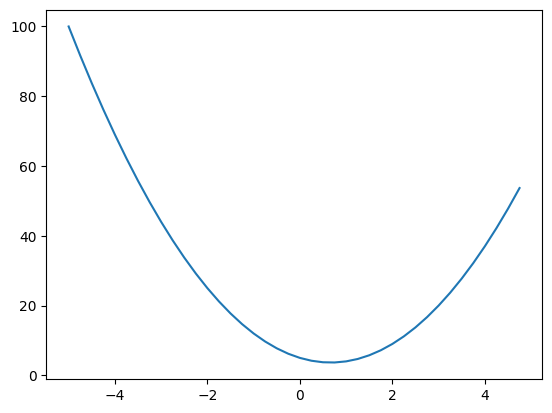

In [6]:
plt.plot(xs, ys)

We get a parabola plot.

What is the derivative of this function at any single input x?

No one in neural nets actually writes out the expression, no one derives the derivative. This would be way to many derivaties, tens of thousands.

So what is a derivative? Well, it is the response from a function at an input point `x` that has received a small bump via `h`. The sensitivity of the change. The slope of a response. Does the function go up or down? And by how much?

We can calculate the derivate here numerically, by taking a small `h`:

In [7]:
h = 0.000000001
x = 3.0
f(x)

20.0

How do we expect this to change? Well, `x=3` results in `y=20`, and is on the part of the parabola that is increasing, so we should expect the small bump fromn `h` to result in a slight positive response.

In [8]:
f(x + h)

20.000000014

The increase from the response tells us the strength of the slope.

In [9]:
(f(x + h) - f(x)) # how much the function responded in the positive direction

1.4000001158365194e-08

In [10]:
(f(x + h) - f(x)) / h # normalizing the response (rise over run) to get the slope

14.000001158365194

Note this is a numerical approximation of the slope, as we need `h` to be very small to converge to the exact amount. Note too many 0s leads to an incorrect answer due to floating point arithmetic - representation of numbers in computer memory is finite!

But essentially, the slope at `x=3` is `14`.

We can see this by taking the derivative of `f(x)`, which is `6x - 4`. 

Plugging in `3` to `f'(x)` yields `6(3) - 4 = 18 - 4 = 14`.

Now what about the slope at `-3`? What is out expectation? The sign of the slope should be negative, as the function goes down with a slight positive bump at `-3`.

In [11]:
h = 0.000000001
x = -3.0
(f(x + h) - f(x)) / h

-22.000001820288162

At some point for this function, the slope will be 0. This occurs at point `2/3`:

In [12]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

At that precise point, if we nudge the function in a positive direction, there is no change as the slope is 0.

# Let's get more complex!

### New Function D

This is a function of three scalar inputs: `a`, `b`, and `c`.

In [13]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


### Derivative of D w.r.t. a

In [14]:
h = 0.0001

# inputs - point fixed
a = 2.0
b = -3.0
c = 10.0

# we will be evaluating the derivative of d, w.r.t. all of a, b, and c - in this case a, as we bump a by a small value here to see the sensitivty of D w.r.t. a change in a
d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # how much the function increased when we bumped the specific input that we are interested in by a tiny amount (normailized by h to get the slope)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


`a` will be slightly more positive from the small bump `h`, but since `b` is negative, we will actually be adding less to `D`. So we expect that the value of the function will go down, which tells us that the slope will be a negative number (we went down).

Also, by calculus we can convince ourselves that the answer is -3 as `dD/da = d(a*b + c)/da) = b` and at this point, `b = -3` so our slope should be `-3`.

### Derivative of D w.r.t. b

In [15]:
h = 0.0001

# inputs - point fixed
a = 2.0
b = -3.0
c = 10.0

# we will be evaluating the derivative of d, w.r.t. all of a, b, and c - in this case b
d1 = a*b + c
b += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


This is the influence of `b` on the output of `D`. Bumping `b` in the positive direction will add more to the output of `D`, since `a` is positive. So, we expect the value of the function to increase, which tells us that the slope is a positive number (we went up).

Again we can convince ourselves by calculus: `dD/db = d(a*b + c)/db = a`. Here, `a = 2`, so our slope is indeed `2`.

### Derivative of D w.r.t. c

In [16]:
h = 0.0001

# inputs - point fixed
a = 2.0
b = -3.0
c = 10.0

# we will be evaluating the derivative of d, w.r.t. all of a, b, and c - this time for c
d1 = a*b + c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


Sensitivty of `D` from change of `c`. Bumping `c` leaves `a*b` unaffected, so all we care about is the `c` term. Increasing `c` will cause the function to increase, so again the slope is a positive number.

And again from calculus: `dD/dc = d(a*b + c)/dc = 1`. The derivative of `c` is just `1`, which matches with our approximation of the converged value.

Note: another way of thinking that the slope is `1` is that our bump by `h` changed the output of `D` by exactly `h`.

# Time to Build out the Value Object

In [43]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0  # 0 means no effect -  we are assuming that at init, every value does not affect the output
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(data=self.data + other.data, _children=(self, other),  _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(data=self.data * other.data, _children=(self, other), _op='*')
        return out

    def tanh(self):
        """
        We could write out exponentiation to construct tanh. However, we don't need the most fundamental pieces in the Value object.
        
        We can create functions at arbitrary points of abstraction. They can be complicated functions or very simple functions. Up to us.
        
        The only thing that matters is that we know how to differentiate through any one function. The function from inputs to output can be arbitrarily complex as long as we know how to create the local derivative.

        Thus, we'll directly implement tanh instead of implementing each of its fundamental pieces.
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(data=t, _children=(self, ), _op='tanh')
        return out

In [18]:
# simple example:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b + c; d.label = 'd'

print(d) # value of d
print(d._prev) # children that made d
print(d._op) # operator to get d

Value(data=4.0)
{Value(data=-6.0), Value(data=10.0)}
+


This tells us that the value of `d` results from the addition of `10` and `-6`.

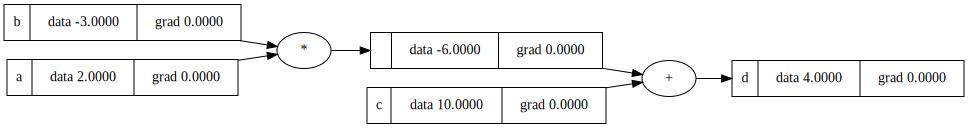

In [19]:
draw_dot(d)

The above visual shows us how we got to `d` from `a*b + c`.

Let's go one layer deeper with `L`:

In [20]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

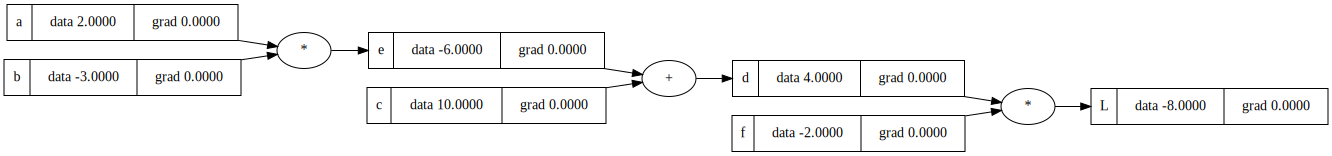

In [21]:
draw_dot(L)

Thus far we have been able to build out mathematical expressions using `+` and `*` so far. They are scalar valued. We can do a forward pass to build a mathematical expression, like `L`.

More explicitly, we have multiple inputs here: `a`, `b`, `c`, and `f`. These inputs are going towards a mathematical expression that produces a single ouput: `L`. This visualization displays the forward pass and its output is `-8`.

What we would like to next is backpropagation. In backpropagation we are going to start at the end, `L`, and reverse and calculate the gradient along all these intermediate values. We are computing the following for every single value: the derivative of that node w.r.t `L`.

The derivative of `L` w.r.t. `L` is `1`. Then we will derive the derivative of `L` w.r.t. `f`, `d`, `e`, and so on.

In a neural network setting, we are interested to the derivative of the output (or loss function, `L`) w.r.t. to its leaf nodes (the weights of the neural net). We need to know how these weights are impacting the loss function. So, we are interested in the derivative of the output w.r.t. to some of its leaf nodes.

The other leaf nodes represent the data itself, but this is not touched as data is fixed (so it doesn't make sense to adjust the loss function based on this). Weights can be iterated upon using gradient information.

## Backprop by hand

So, our grad property represents the derivative of the output (in our case `L`) w.r.t. a node value (i.e. `f`).

Let's start by calculating the gradients:
- What is the derivative of `L` w.r.t. `L`? In other words, if I have `L` by a tiny amount `h`, how much does `L` change? It changes by `h`. It is proportional so the derivative is `1`.

In [22]:
def dL_da():
    """
    This function approximates dL/da, in other words this function tells us how much L changes if we change a by a small amount (h)

    In other words, the sensitivity of L to a.
    """
    h = 0.0001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label = 'a')  # this would be measuring the derivative of L w.r.t. a
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)  # L2 - L1 tells us how much L changed, dividing by h will normalize the change

dL_da()

6.000000000021544


In [23]:
def dL_dL():
    """
    We can do the same for L

    And you can see that the derivative is 1 - any change to L changes L by that change
    """
    h = 0.0001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data + h  # this would be measuring the derivative of L w.r.t. L

    print((L2 - L1) / h)  # L2 - L1 tells us how much L changed, dividing by h will normalize the change

dL_dL()

0.9999999999976694


We can think of `dL/dL` as our base case. This would mean that `L.grad` is `1`. We can re-draw:

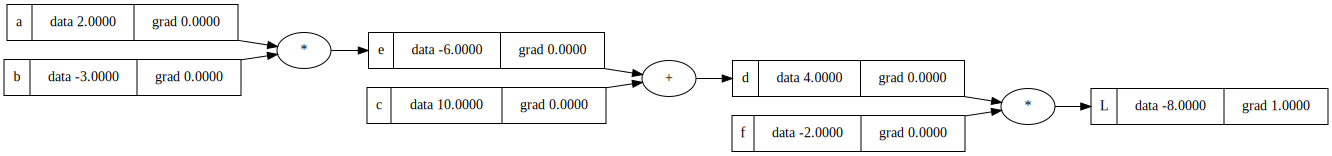

In [24]:
L.grad = 1.0
draw_dot(L)

We can continue to find the grad at each node.

We know that `L = d * f` and we would like to know what `dL/dd` is, which is `f`.

**Proof:**

```
Definition of the deriviative: (f(x + h) - f(x)) / h (as limit of h goes to 0)
((d+h)*f - d*f) / h
(d*f + h*f - d*f) / h
(h*f) / h
f
```

*q.e.d*

Symetrically, `dL/df` is `d`.

Let us re-draw again:

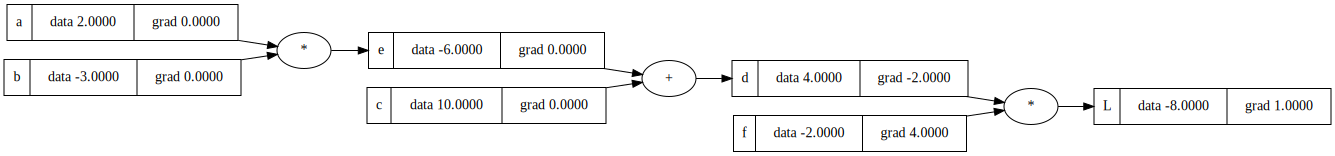

In [25]:
f.grad = 4.0
d.grad = -2.0
draw_dot(L)

You could copy the above `dL_da` function and modify it to verify that our calculus is correct for the grad values above. This would be an inline gradient check. 

Gradient check is when we are deriving this backpropagation and getting derivaties w.r.t. all the intermediate results. Numerical gradient is just estimating it using small step size (i.e. the functions).

This next derivative is the crux of backprop. If you understand this, you understand all of backpropagation.

What is `dL/dc`? How do we derive `dL/dc`? We know how `L` is sensitive to `d`, but how is `L` sensitive to `c`? So, if we wiggle `c`, how does that impact `L`, through `d`.

Intuitively, if you know the impact `c` is having on `d`, and you know the impact `d` is having on `L`, then you should be able to put that information together to determine how `c` impacts `L`.

What is `dd/dc`? `d = e + c` so `d(e + c) / dc = 1`.

Karpathy refers to this as the *local derivative* because the `+` node knows nothing about the rest of the embedded graph, this `+` node knows the local influence of `c` on `d` (or rather `dd/dc`, as well as `dd/de`), but this isn't what we want (it is just the local derivative). What we actual want is `dL/dc`. In the general case, this `+` node could be embedded in a massive graph. A `+` node just routes the gradient, because the `+` nodes local derivaties are just `1`, and in the chain rule `1` * `dL/dd` is just `dL/dd`. So, the derivative of `dL/dd` is simply routed to both `c` and `e` in this case.

Now that we have both the impact of `c` on `d`, and the impact of `d` on `L`, how do we put it together?

Well, we need the **chain rule** for this: `dL/dc = dL/dd * dd/dc`. Recall, `dL/dd = -2` and `dd/dc = 1`. Thus, `dL/dc = -2 * 1 = -2`.

To differentiate through a function composition, we have to apply a multiplication of those derivatives (multiply intermediate rates of change). **Intuitively**, *if a car travels twice as fast as a bike and the bike is four times as fast as a walking man, then the car travels `2*4 = 8` times as fast as the man*.

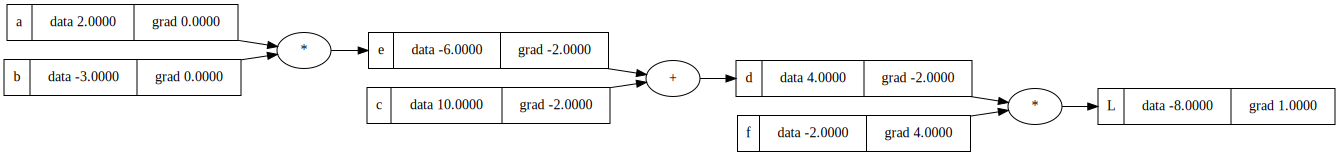

In [26]:
c.grad = -2
e.grad = -2 # by symmetry
draw_dot(L)

This backprop signal, which is carrying the information of *"what is the derivative of `L` w.r.t. all of the intermediate nodes?"*, we can imagine it almost like flowing backwards through the graph and a `+` node will simply distribute the derivative to all of the children nodes of `L`.

Again we can verify by function:

In [27]:
def dL_dc():
    """
    Verifying our gradient signal being distributed through the `+` sign to the child node of c.

    The same applies to e by symmetry.
    """
    h = 0.0001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    c.data += h # this would be measuring the derivative of L w.r.t. c
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)  # L2 - L1 tells us how much L changed, dividing by h will normalize the change

dL_dc()

-1.9999999999953388


Now we recurse our way backwards again to find the gradient of `a` and `b`. Again, we will apply the chain rule (in general cases it gets applied all the way through the graph).

So, what is `dL/da`?

Recall: `dL/de = -2`. The chain rule tells us that `dL/da = dL/de * de/da`!

So, what is `de/da`? For reference: `e = a * b`. This gives us `de/da = b`, which is `-3`.

`dL/da = -2 * -3 = 6`.

Similarly, `dL/db = dL/de * de/db = -2 * 2 = -4`.

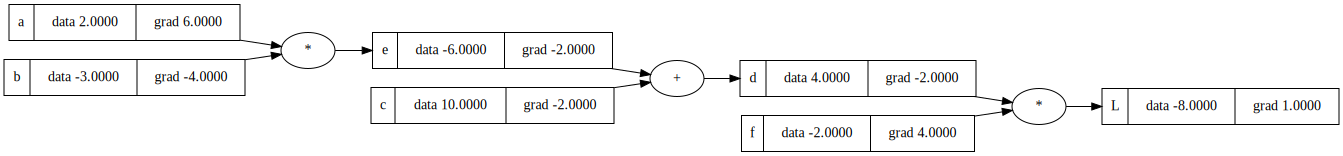

In [28]:
a.grad = 6
b.grad = -4
draw_dot(L)

This can be verified again, but I'll leave that as an exercise to the reader. This is manual backprop!

All we have done is iterate through all of the nodes, one-by-one, and locally applied the chain rule. We always know what the derivative of `L` is w.r.t. this local output and then we look at how this output was produced. This output was produced through some operation and we have the pointers to the children nodes of this operation, and so in this operation we know what the local derivaties are and we just multiple them onto the derivative always. We recursively multiply on the local derivatives. 

Backprop is just a recursive application of chain rule, backwards through the computation graph.

## Seeing how gradients can change output

Let's see this power in action! We will try to nudge our inputs to make `L` increase.

**Note:** we are only nudging our leaf nodes (this simulates the inputs we have control over, aka the weights).

In [29]:
step_size = 0.01
a.data += step_size * a.grad # if we want L to increase, we just need to head into the direction of the gradient
b.data += step_size * b.grad
c.data += step_size * c.grad
f.data += step_size * f.grad

# need to re-run the forward pass
e = a * b
d = e + c
L = d * f

print(L.data) # we expect to go up since all of our inputs where nudged in the direction of their gradient

-7.286496


This is basically one step of an optimization that will end up running iteratively. The gradients give us power, as we know how to influence the final outcome, which is extremely useful for training neural nets.

# A More Complex and Useful Backprop Example

We are going to backprop through a neuron. We want to build out a neural network. In the simplest case, these are multi-layer perceptrons.

A biological analogy (neural nets are inspired after neurons after all) below:

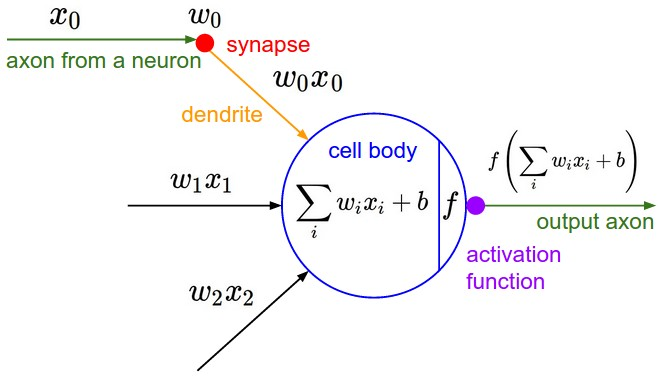

In [30]:
from IPython.display import Image
Image(filename='./neuron_model.jpeg') 

`b` represents the bias of the cell body, an innate property that might make a neuron more or less likely to fire. `f` is typically some sort of squashing function like sigmoid or tanh.

A visualization of tanh below:

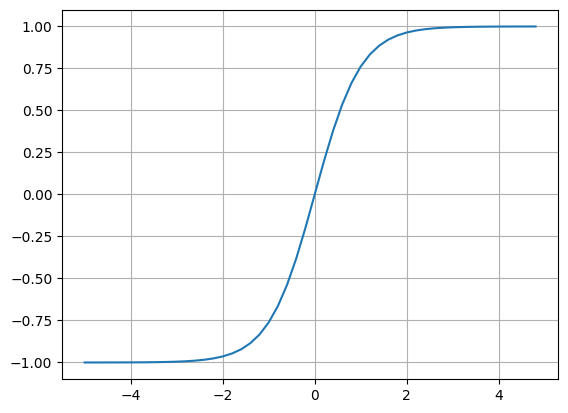

In [32]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

Very positive inputs cap smoothly at `1`. Very negative inputs cap smoothly at `-1`. Any input of `0` results in no activation, or an output of `0`.

Let's write out a neuron:

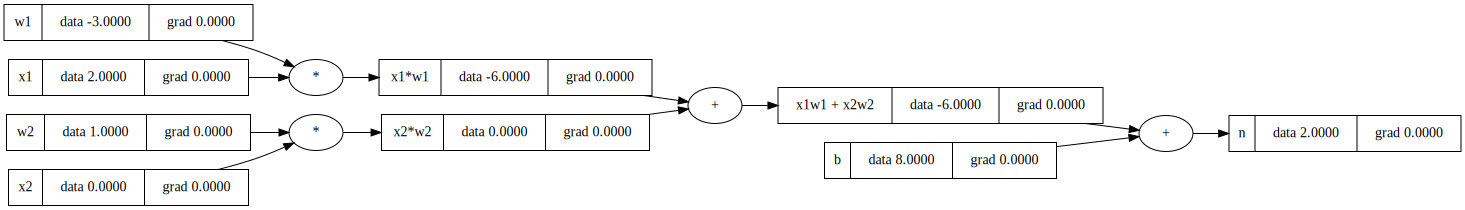

In [47]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (the synaptic strength for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(8, label='b')

# summation of our weighted inputs with bias (x1w1 + x2w2 + b)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the raw activation of the cell body - without the activation function

draw_dot(n)

Now we want to apply the activation function, tanh. However, we will need to implement out tanh. You can't make tanh from simply `+` and `*`. You also need exponetiation! We will need to modify the `Value` class.

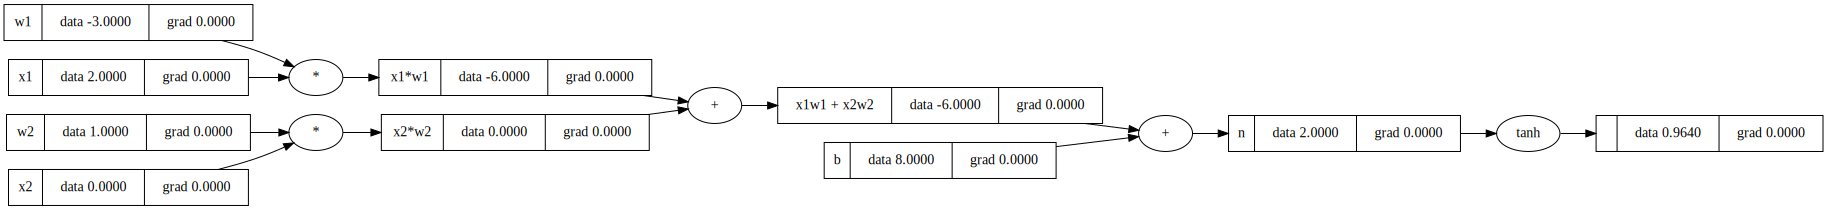

In [48]:
o = n.tanh()
draw_dot(o)

We can see tanh squashing the value of `n` from `2` to `0.96`

Now for a cleaner backprop case:

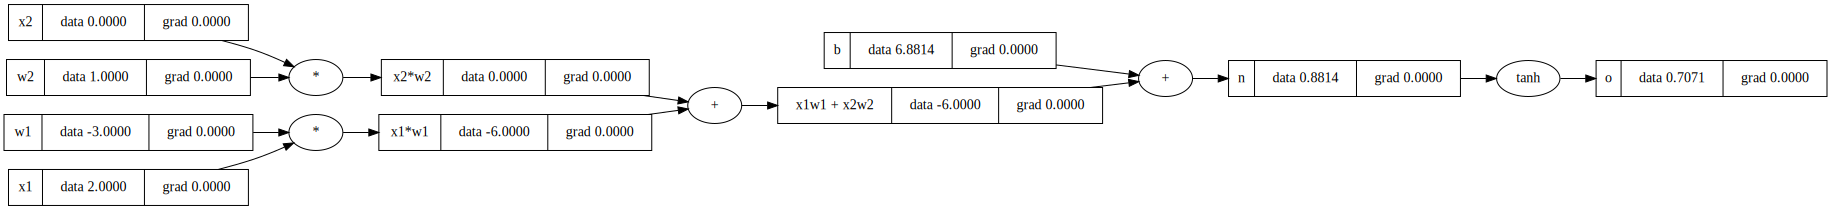

In [50]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (the synaptic strength for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# summation of our weighted inputs with bias (x1w1 + x2w2 + b)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the raw activation of the cell body - without the activation function

o = n.tanh(); o.label = 'o'
draw_dot(o)

Now we do backprop by hand.

What is the derivative of `o` w.r.t. all of our inputs? In a real neural network setting, we only really care about the derivatives of the neurons on the weights (e.g. `w2` and `w1` because that is what we can change). The other thing to keep in mind is that this is only one neuron. So, it is only a small piece of the puzzle for the whole neural network.

Let's start with the base case. What is `do/do`? This is `1`.

In [51]:
o.grad = 1.0

Now we need to backprop through out activation function, `tanh`. We need to know the local derivative of `tanh`.

We know that `o = tanh(n)`. What is `do/dn`?

Well `d/dx(tanh(x)) = 1 - tanh(x)**2`. Thus, `do/dn = 1 - tanh(n)**2`.

We already have `tanh(n)`, it is `o`, which is `0.7071`.

Plugging in: `do/dn = 1 - tanh(n)**2 = 1 - (0.7071)**2 = 0.5`.

In [53]:
n.grad = 0.5

We continue backprop here through the `+` sign. Recall from the previous example that a `+` is just a distributor of the gradient. So, this gradient will simply flow to both of these nodes equally (again b/c the local derivative is 1 for every single node).

Thus, `dn/db = 0.5` and the same applies by symmetry to our node `x1w1 + x2w2`.

In [55]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

Continuing, we have another `+`!

In [57]:
x2w2.grad = 0.5
x1w1.grad = 0.5

Now, let's propagate to `x2` and `w2` first.

This is a `*` term, so we know that the local derivative of the node is the other term. For example: `d(x1w1x2w2)/d(x2) = d(x1w1x2w2)/d(x2w2) * d(x2w2)/d(x2) = 0.5 * w2 = 0.5 * 1`.

In [59]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

Similarly for `x1` and `w1`:

`d(x1w1x2w2)/d(x1) = d(x1w1x2w2)/d(x1w1) * d(x1w1)/d(x1) = 0.5 * w1 = 0.5 * -3 = -1.5`

In [61]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

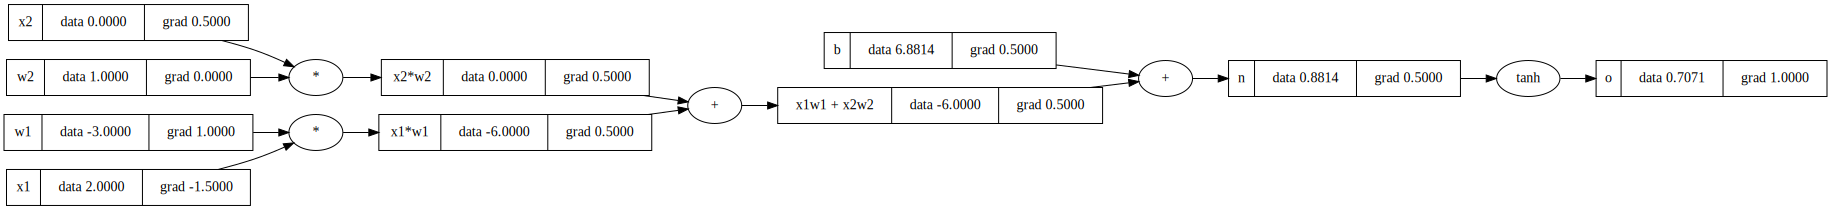

In [62]:
draw_dot(o)

When thinking about these local derivatives, it is the grad of the parent node multiplied by the grad of the local term (or child node). Now, in the case of `+`, the local term's multiplier in the chain rule is `1`. In the case of `*`, the multiplier would be the other term (i.e. if we are getting the derivative of `x2w2` w.r.t. to `x2` the multiplier becomes `w2`). Now, since we are also using the chain rule, the grad that is calculated at each term tells us how much `o` would change with a push to the term. We have propagated the rates of change backwards - backprop!

Some other things to observe:
- `w2` has no gradient => `w2` has no impact on this neuron
- `w1` should increase to increase the value of our output, since the grad of `w1` is positive (this would also be proportionally since the gradient is `1`).
- 

In [67]:
# an example of how increasing n will increase o by half as much -> checks out since our gradient is 0.5
np.tanh(0.8814), np.tanh(0.90), 0.9 - 0.8814, (np.tanh(0.90) - np.tanh(0.8814)) * 2

(0.7071199874301226,
 0.7162978701990245,
 0.01860000000000006,
 0.018355765537803714)

In [89]:
# the same idea applies if we change w1 -> increased w1 by 1 -> n is increased by 2 -> which means our tanh seems the proportional increase (b/c chaning n by 2 changes tanh by half as much
n_start = (-3 * 2 + 1 * 0) + 6.8814
n_nudged_at_w1 = ((-3 + 1) * 2 + 1 * 0) + 6.8814
print("Seeing rate of change with do/dn as a bridge rate")
print(n_start, n_nudged_at_w1)

Seeing rate of change with do/dn as a bridge rate
0.8814000000000002 2.8814
